In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import IPython
import IPython.display
import tensorflow as tf
from tensorflow import keras
from matplotlib import rcParams

from scipy import io
from scipy.interpolate import interp1d
import os
from sklearn.metrics import accuracy_score, f1_score,mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from scipy.special import expit  # For sigmoid function
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, t
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import t
from scipy.io import loadmat
from tqdm import tqdm
import scipy
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data():
        # Load data
    data = scipy.io.loadmat('C:\\Users\\Oleg\\Desktop\\Paris_Saclay\\These\\5_MODEL\\AI_model\\trajectories.mat')
    
    # Path
    iid = data['iidind'][2:,]
    rdw = data['rdwind'][2:,]
    posr = np.zeros((iid.shape[0] - 1, iid.shape[1]))
    posw = np.zeros((rdw.shape[0]-1, rdw.shape[1]))
    n_path = posr.shape[1]
    invis = []

    for tidx in range(n_path):
        # IID
        invisR = int(iid[0, tidx])
        
        invis.append(invisR)
        r = iid[1:, tidx].copy()
        #r[-invisR + 1:] = np.nan
        r[-invisR + 1:] = 0
        posr[:, tidx] = r
        # rdw 
        w = rdw[1:, tidx].copy()
        #w[-invisR+1:] = np.nan
        w[-invisR+1:] = 0
        posw[:, tidx] = w

    
    posw_same = np.hstack((posw[:,0:50], posw[:,150:]))
    posw_opposite = posw[:,50:150]
    # Create a list of columns from posr without NaN values
    path_rdw_s = [np.array(col[~np.isnan(col)]) for col in posw_same.T]
    path_rdw_op =[np.array(col[~np.isnan(col)]) for col in posw_opposite.T]


    posr_same = np.hstack((posr[:,0:50], posr[:,150:]))
    posr_opposite = posr[:,50:150]
    # Create a list of columns from posr without NaN values
    path_iid_s = [np.array(col[~np.isnan(col)]) for col in posr_same.T]
    path_iid_op =[np.array(col[~np.isnan(col)]) for col in posr_opposite.T]    
    print(np.max(invis))
    return path_iid_s, path_iid_op, path_rdw_s, path_rdw_op


def load_responses(resp_array):
    resp_same =  np.vstack((resp_array[0:50:,], resp_array[150::,]))
    resp_op = resp_array[50:150:,]
    return resp_same,resp_op



In [3]:
path_iid_s, path_iid_op, path_rdw_s, path_rdw_op = load_data()


rt_rdw = pd.read_csv('C:/Users/Oleg/Desktop/Paris_Saclay/These/4_DATA/data_exp_1/resp/Subjects_28_pross_rt/pros_rt_rdw.csv', header=None).to_numpy()
rt_iid = pd.read_csv('C:/Users/Oleg/Desktop/Paris_Saclay/These/4_DATA/data_exp_1/resp/Subjects_28_pross_rt/pros_rt_iid.csv', header=None).to_numpy()
resp_rdw = pd.read_csv('C:/Users/Oleg/Desktop/Paris_Saclay/These/4_DATA/data_exp_1/resp/Subjects_28_pross_rt/resp_rdw.csv', header=None).to_numpy()
resp_iid = pd.read_csv('C:/Users/Oleg/Desktop/Paris_Saclay/These/4_DATA/data_exp_1/resp/Subjects_28_pross_rt/resp_iid.csv', header=None).to_numpy()

acc_rdw = pd.read_csv('C:/Users/Oleg/Desktop/Paris_Saclay/These/4_DATA/data_exp_1/resp/Subjects_28_pross_rt/acc_rdw.csv', header=None).to_numpy()
acc_iid = pd.read_csv('C:/Users/Oleg/Desktop/Paris_Saclay/These/4_DATA/data_exp_1/resp/Subjects_28_pross_rt/acc_iid.csv', header=None).to_numpy()

resp_iid_same,resp_iid_op= load_responses(resp_iid)
resp_rdw_same,resp_rdw_op= load_responses(resp_rdw)

resp_iid_same = 1 - resp_iid_same
resp_iid_op = 1 - resp_iid_op
resp_rdw_same = 1 - resp_rdw_same
resp_rdw_op = 1 - resp_rdw_op

49


In [4]:

def reindex_from_last_visible_fixed_length(data, total_points=150, invisible_marker=0.0):

    reindexed_trajectories = []

    for trajectory in data:

        invis_indices = np.where(trajectory[1:] == invisible_marker)[0]

        if len(invis_indices) > 0:
            last_visible_idx = invis_indices[0] 
        else:
            last_visible_idx = len(trajectory) 

        visible_part = trajectory[:last_visible_idx + 1]

        reindexed = np.zeros(total_points, dtype=float)
        visible_length = len(visible_part)
        reindexed[-visible_length:] = visible_part  # Place visible part at the end

        reindexed_trajectories.append(reindexed)

    df = pd.DataFrame(reindexed_trajectories)

    column_names = [f"p_last-{i}" if i > 0 else "p_last" for i in range(total_points - 1, -1, -1)]
    df.columns = column_names

    return df


In [7]:
def normalize_data_zero_one(np_array):

    if not isinstance(np_array, np.ndarray):
        raise TypeError("Input must be a numpy array.")
    
    global_min = np.min(np_array)
    global_max = np.max(np_array)
    
    if global_max == global_min:
        raise ValueError("All values are the same; scaling is not possible.")
    
    normalized_array = (np_array - global_min) / (global_max - global_min)
    
    return normalized_array

def normalize_data(np_array):

    
    global_min = np.nanmin(np_array)
    global_max = np.nanmax(np_array)

    normalized_array = 2 * ((np_array - global_min) / (global_max - global_min)) - 1
    
    return normalized_array

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

def run_random_forest_with_feature_importance(trajectories, responses, random_state=42):

    trajectories = np.array(trajectories)
    n_trajectories, n_positions = trajectories.shape
    n_participants = responses.shape[1]

    results = {}

    # Определение параметров для поиска
    param_grid = {
        "n_estimators": [20, 40, 60, 80,],
        "max_depth": [3, 5, 10, 15],
        "min_samples_split": [2, 5, 10]
    }

    for participant_idx in range(n_participants):
        participant_responses = responses[:, participant_idx]

        trajectories_norm = normalize_data(trajectories)

        base_model = RandomForestClassifier(random_state=random_state)

        grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
        grid_search.fit(trajectories_norm, participant_responses)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(trajectories_norm)
        y_proba = best_model.predict_proba(trajectories_norm)[:, 1]

        accuracy = accuracy_score(participant_responses, y_pred)
        roc_auc = roc_auc_score(participant_responses, y_proba)
        classification_metrics = classification_report(participant_responses, y_pred, output_dict=True)

        results[participant_idx] = {
            "model": best_model,
            "best_params": best_params,
            "feature_importances": best_model.feature_importances_,
            "accuracy": accuracy,
            "roc_auc": roc_auc,
            "classification_metrics": classification_metrics,
            "predicted_probabilities": y_proba
        }

    return results


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
# n_estimators=30
def run_random_forest_with_feature_importance(trajectories, responses, n_estimators=30, random_state=42):

    trajectories = np.array(trajectories)
    n_trajectories, n_positions = trajectories.shape
    n_participants = responses.shape[1]

    results = {}

    for participant_idx in range(n_participants):
        participant_responses = responses[:, participant_idx]

        trajectories = normalize_data(trajectories)

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=random_state,
      

        )
        model.fit(trajectories, participant_responses)

        
        y_pred = model.predict(trajectories)
        y_proba = model.predict_proba(trajectories)[:, 1]

        accuracy = accuracy_score(participant_responses, y_pred)
        roc_auc = roc_auc_score(participant_responses, y_proba)
        classification_metrics = classification_report(participant_responses, y_pred, output_dict=True)

        results[participant_idx] = {
            "model": model,
            "feature_importances": model.feature_importances_,
            "accuracy": accuracy,
            "roc_auc": roc_auc,
            "classification_metrics": classification_metrics,
            "predicted_probabilities": y_proba
        }

    return results


In [18]:
df_rdw_same = reindex_from_last_visible_fixed_length(path_rdw_s)
df_rdw_op = reindex_from_last_visible_fixed_length(path_rdw_op)
df_iid_same = reindex_from_last_visible_fixed_length(path_iid_s)
df_iid_op = reindex_from_last_visible_fixed_length(path_iid_op)

df_rdw_same =df_rdw_same.iloc[:,109:]
df_rdw_op = df_rdw_op.iloc[:,109:]
df_iid_same = df_iid_same.iloc[:,109:]
df_iid_op = df_iid_op.iloc[:,109:]

In [19]:
results_rdw_same = run_random_forest_with_feature_importance(df_rdw_same.to_numpy(), resp_rdw_same)
results_rdw_op = run_random_forest_with_feature_importance(df_rdw_op.to_numpy(), resp_rdw_op)
results_iid_same = run_random_forest_with_feature_importance(df_iid_same.to_numpy(), resp_iid_same)
results_iid_op = run_random_forest_with_feature_importance(df_iid_op.to_numpy(), resp_iid_op)

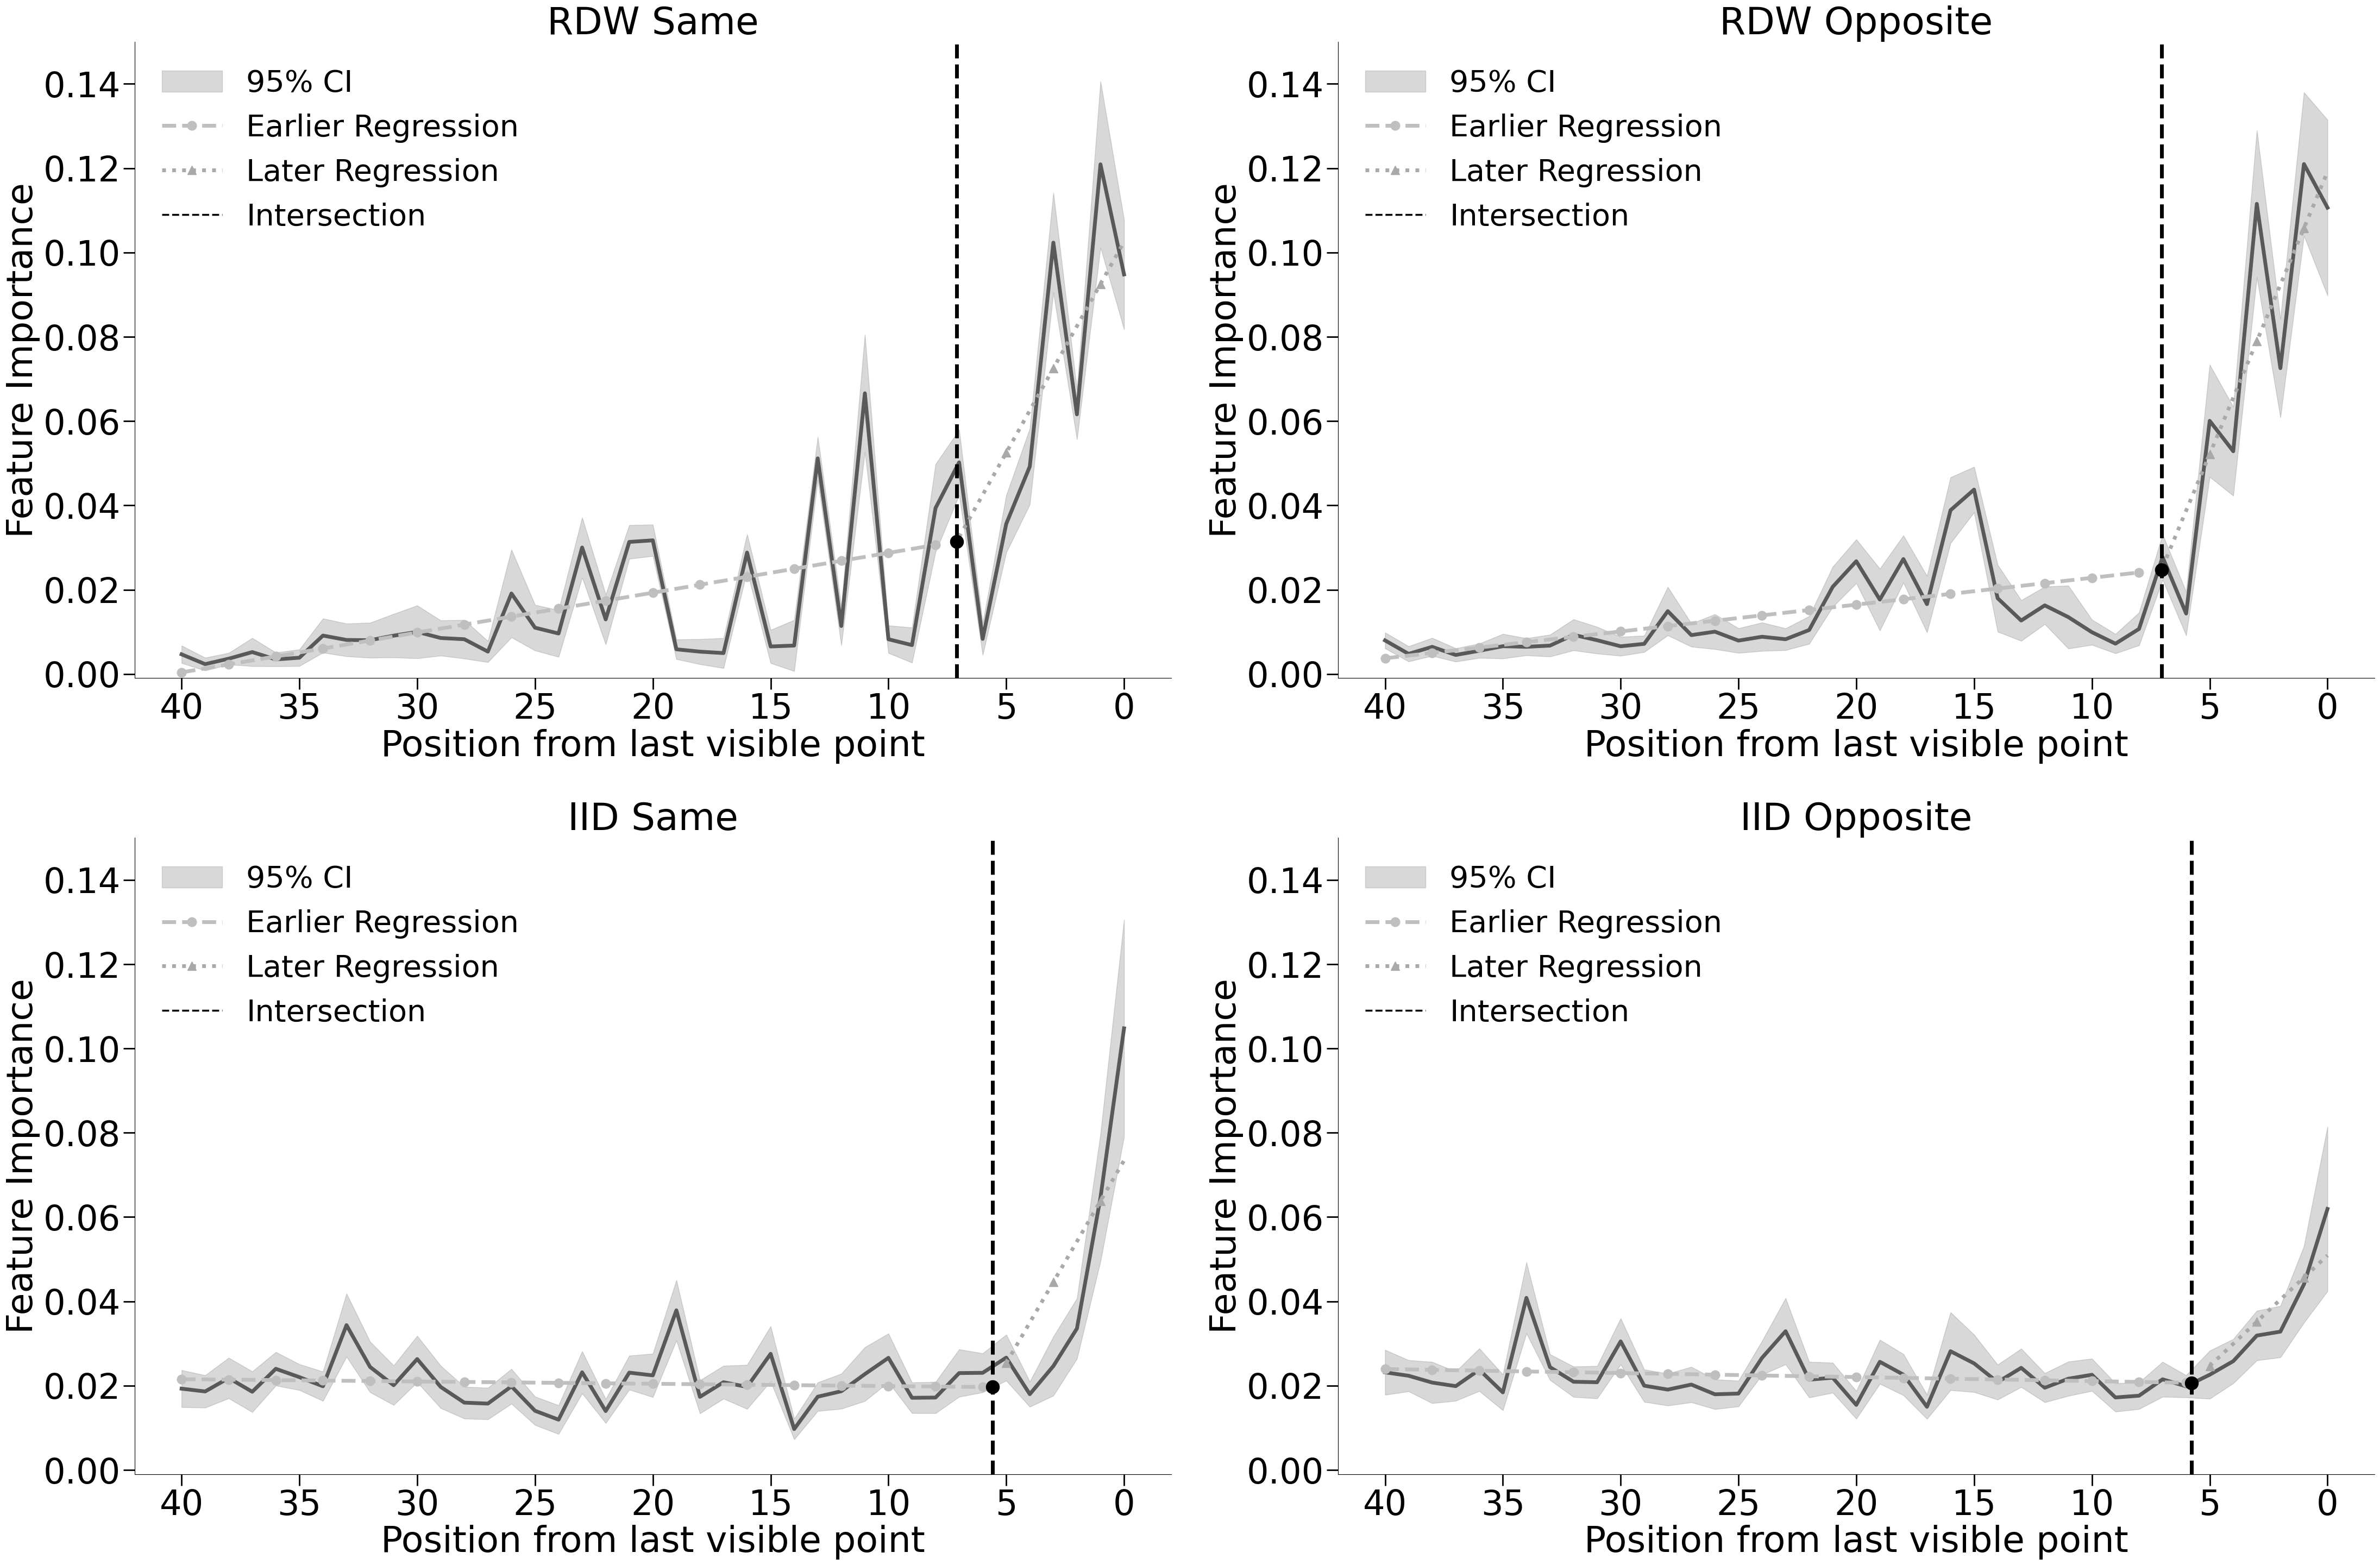

In [20]:
fig, results = find_optimal_split_and_plot_subplots(results_rdw_same, results_rdw_op, results_iid_same, results_iid_op)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, classification_report


def compute_confidence_interval_range(data, confidence=0.95):

    mean = np.mean(data, axis=0)
    ci_range = t.interval(confidence, len(data) - 1, loc=mean, scale=st.sem(data, axis=0))
    ci_lower, ci_upper = ci_range
    return mean, ci_lower, ci_upper
def run_random_forest_with_cross_validation(trajectories, responses, n_estimators=50, random_state=42, cv=5):

    trajectories = np.array(trajectories)
    n_trajectories, n_positions = trajectories.shape
    n_participants = responses.shape[1]

    results = {}

    for participant_idx in range(n_participants):
        participant_responses = responses[:, participant_idx]

        trajectories = normalize_data(trajectories)

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=random_state,
            class_weight="balanced"
        )

        scoring = {
            'accuracy': make_scorer(accuracy_score),
            'roc_auc': make_scorer(roc_auc_score)
        }
        cv_results = cross_validate(model, trajectories, participant_responses, cv=cv, scoring=scoring, return_estimator=True)

        avg_cv_accuracy = np.mean(cv_results['test_accuracy'])
        avg_cv_roc_auc = np.mean(cv_results['test_roc_auc'])

        best_model_idx = np.argmax(cv_results['test_accuracy'])
        best_model = cv_results['estimator'][best_model_idx]  

        feature_importances = best_model.feature_importances_

        results[participant_idx] = {
            "model": best_model,
            "feature_importances": feature_importances,
            "cv_accuracy": avg_cv_accuracy,
            "cv_roc_auc": avg_cv_roc_auc,
            "cv_accuracy_scores": cv_results['test_accuracy'],
            "cv_roc_auc_scores": cv_results['test_roc_auc']
        }

    return results


In [230]:
results_rdw_same = run_random_forest_with_cross_validation(df_rdw_same.to_numpy(), resp_rdw_same)
results_rdw_op = run_random_forest_with_cross_validation(df_rdw_op.to_numpy(), resp_rdw_op)
results_iid_same = run_random_forest_with_cross_validation(df_iid_same.to_numpy(), resp_iid_same)
results_iid_op = run_random_forest_with_cross_validation(df_iid_op.to_numpy(), resp_iid_op)

In [231]:
def compute_average_metrics(results):

    cv_accuracies = [result["cv_accuracy"] for result in results.values()]
    cv_roc_aucs = [result["cv_roc_auc"] for result in results.values()]
    
    avg_cv_accuracy = np.mean(cv_accuracies)
    avg_cv_roc_auc = np.mean(cv_roc_aucs)
    
    return avg_cv_accuracy, avg_cv_roc_auc


avg_cv_acc_rdw_same, avg_cv_roc_rdw_same = compute_average_metrics(results_rdw_same)
avg_cv_acc_rdw_op, avg_cv_roc_rdw_op = compute_average_metrics(results_rdw_op)
avg_cv_acc_iid_same, avg_cv_roc_iid_same = compute_average_metrics(results_iid_same)
avg_cv_acc_iid_op, avg_cv_roc_iid_op = compute_average_metrics(results_iid_op)

print(f"RDW Same:      CV Accuracy = {avg_cv_acc_rdw_same:.4f}, CV ROC AUC = {avg_cv_roc_rdw_same:.4f}")
print(f"RDW Opposite:  CV Accuracy = {avg_cv_acc_rdw_op:.4f}, CV ROC AUC = {avg_cv_roc_rdw_op:.4f}")
print(f"IID Same:      CV Accuracy = {avg_cv_acc_iid_same:.4f}, CV ROC AUC = {avg_cv_roc_iid_same:.4f}")
print(f"IID Opposite:  CV Accuracy = {avg_cv_acc_iid_op:.4f}, CV ROC AUC = {avg_cv_roc_iid_op:.4f}")


RDW Same:      CV Accuracy = 0.9136, CV ROC AUC = 0.9108
RDW Opposite:  CV Accuracy = 0.8546, CV ROC AUC = 0.8514
IID Same:      CV Accuracy = 0.7521, CV ROC AUC = 0.7361
IID Opposite:  CV Accuracy = 0.6393, CV ROC AUC = 0.5950


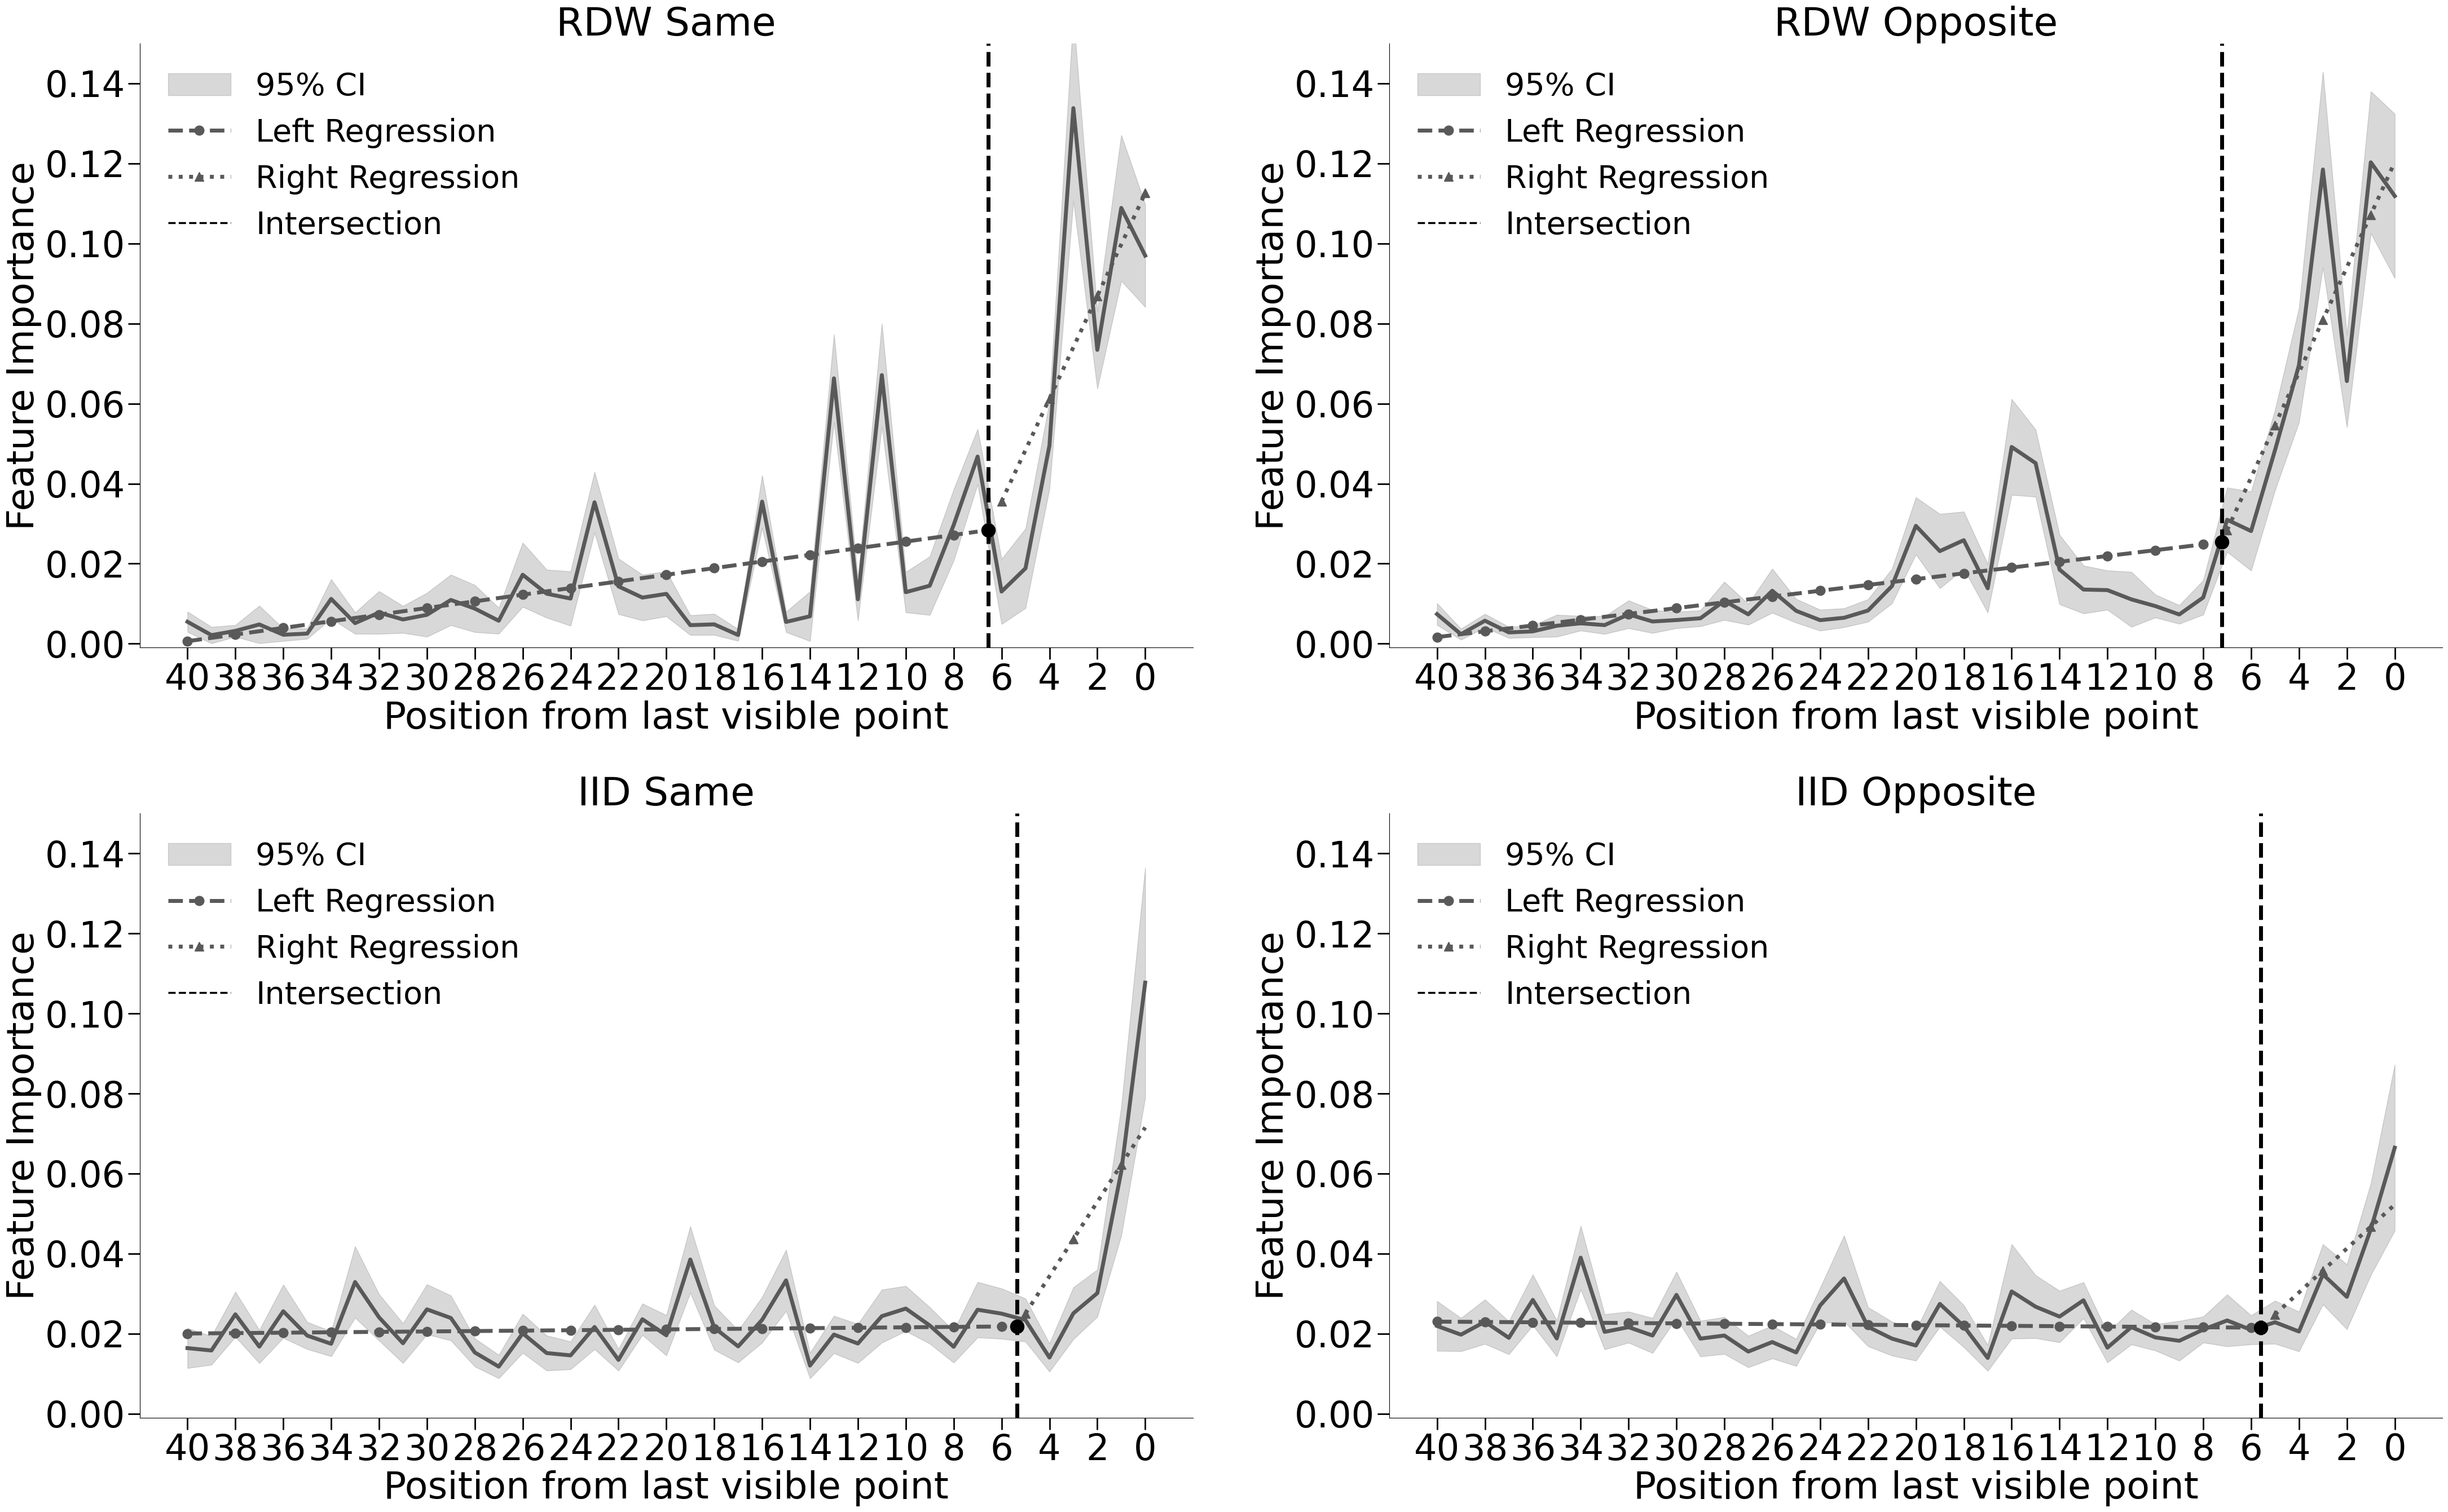

In [212]:
find_optimal_split_and_plot_subplots(results_rdw_same, results_rdw_op, results_iid_same, results_iid_op)

In [13]:
def find_optimal_split_and_plot_subplots(results_rdw_same, results_rdw_op, results_iid_same, results_iid_op):
    conditions = {
        "RDW Same": results_rdw_same,
        "RDW Opposite": results_rdw_op,
        "IID Same": results_iid_same,
        "IID Opposite": results_iid_op
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(45, 30))  
    axes = axes.flatten()
    
    font_size = 46 

    colors = ['#595959', '#7F7F7F', '#BFBFBF', '#A9A9A9']  
    
    all_results = {}  
    
    for idx, (cond, results) in enumerate(conditions.items()):
        rdw_coefficients = [participant["feature_importances"] for participant in results.values()]
        rdw_mean, ci_lower, ci_upper = compute_confidence_interval_range(rdw_coefficients)    
        positions = np.arange(1, len(rdw_mean) + 1)
        
        def calculate_error_and_intersection(x0):
            left_positions = positions[:x0]
            right_positions = positions[x0:]
            left_mean = rdw_mean[:x0]
            right_mean = rdw_mean[x0:]
            slope_left, intercept_left, _, _, _ = linregress(left_positions, left_mean)
            slope_right, intercept_right, _, _, _ = linregress(right_positions, right_mean)
            if slope_left != slope_right:
                x_intersect = (intercept_right - intercept_left) / (slope_left - slope_right)
            else:
                x_intersect = np.nan 
            left_fit = slope_left * left_positions + intercept_left
            right_fit = slope_right * right_positions + intercept_right
            total_error = np.sum((left_mean - left_fit) ** 2) + np.sum((right_mean - right_fit) ** 2)
            return total_error, x_intersect, (slope_left, intercept_left), (slope_right, intercept_right)
        
        best_x0 = None
        best_error = float('inf')
        best_intersection = None
        best_models = None
        for x0 in range(30, len(positions) - 7):  
            error, intersection, left_model, right_model = calculate_error_and_intersection(x0)
            if error < best_error:
                best_x0 = x0
                best_error = error
                best_intersection = intersection
                best_models = (left_model, right_model)
        
        slope_left, intercept_left = best_models[0]
        slope_right, intercept_right = best_models[1]
        
        regression_left = slope_left * positions[:int(best_intersection)] + intercept_left
        regression_right = slope_right * positions[int(best_intersection):] + intercept_right
        
        ax = axes[idx]  
        ax.plot(positions, rdw_mean, color=colors[0], linewidth=4, linestyle='-')
        ax.fill_between(positions, ci_lower, ci_upper, color=colors[1], alpha=0.3, label="95% CI")
        ax.plot(positions[:int(best_intersection)], regression_left, '--', 
                label=f"Earlier Regression", color=colors[2], linewidth=5, marker='o', markevery=2, markersize=12)
        ax.plot(positions[int(best_intersection):], regression_right, ':', 
                label=f"Later Regression", color=colors[3], linewidth=5, marker='^', markevery=2, markersize=12)
        
        if not np.isnan(best_intersection):
            ax.axvline(x=best_intersection, color='black', linestyle="--", label=f"Intersection", linewidth=2.5)
            ax.scatter([best_intersection], [slope_left * best_intersection + intercept_left], color='black', zorder=5, s=300)
        
        ax.set_title(f"{cond}", fontsize=font_size + 4,)
        ax.set_xlabel("Position from last visible point", fontsize=font_size + 2)
        ax.set_ylabel("Feature Importance", fontsize=font_size + 2)
        x_labels = [f"{i}" for i in range(len(rdw_mean) - 1, -1, -5)]
        x_ticks = positions[::5]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels, rotation=0, fontsize=font_size)
        ax.set_ylim(-0.001, 0.15)
        ax.legend(fontsize=40, loc='upper left', frameon=False)
        ax.tick_params(axis='both', labelsize=font_size, length=15, width=2)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.setp(ax.lines, linewidth=5)
        
        all_results[cond] = {
            "best_x0": best_x0,
            "best_intersection": best_intersection,
            "best_error": best_error,
            "left_regression_model": {"slope": slope_left, "intercept": intercept_left},
            "right_regression_model": {"slope": slope_right, "intercept": intercept_right}
        }
    
    plt.tight_layout(pad=5.0)
   
    return fig, all_results

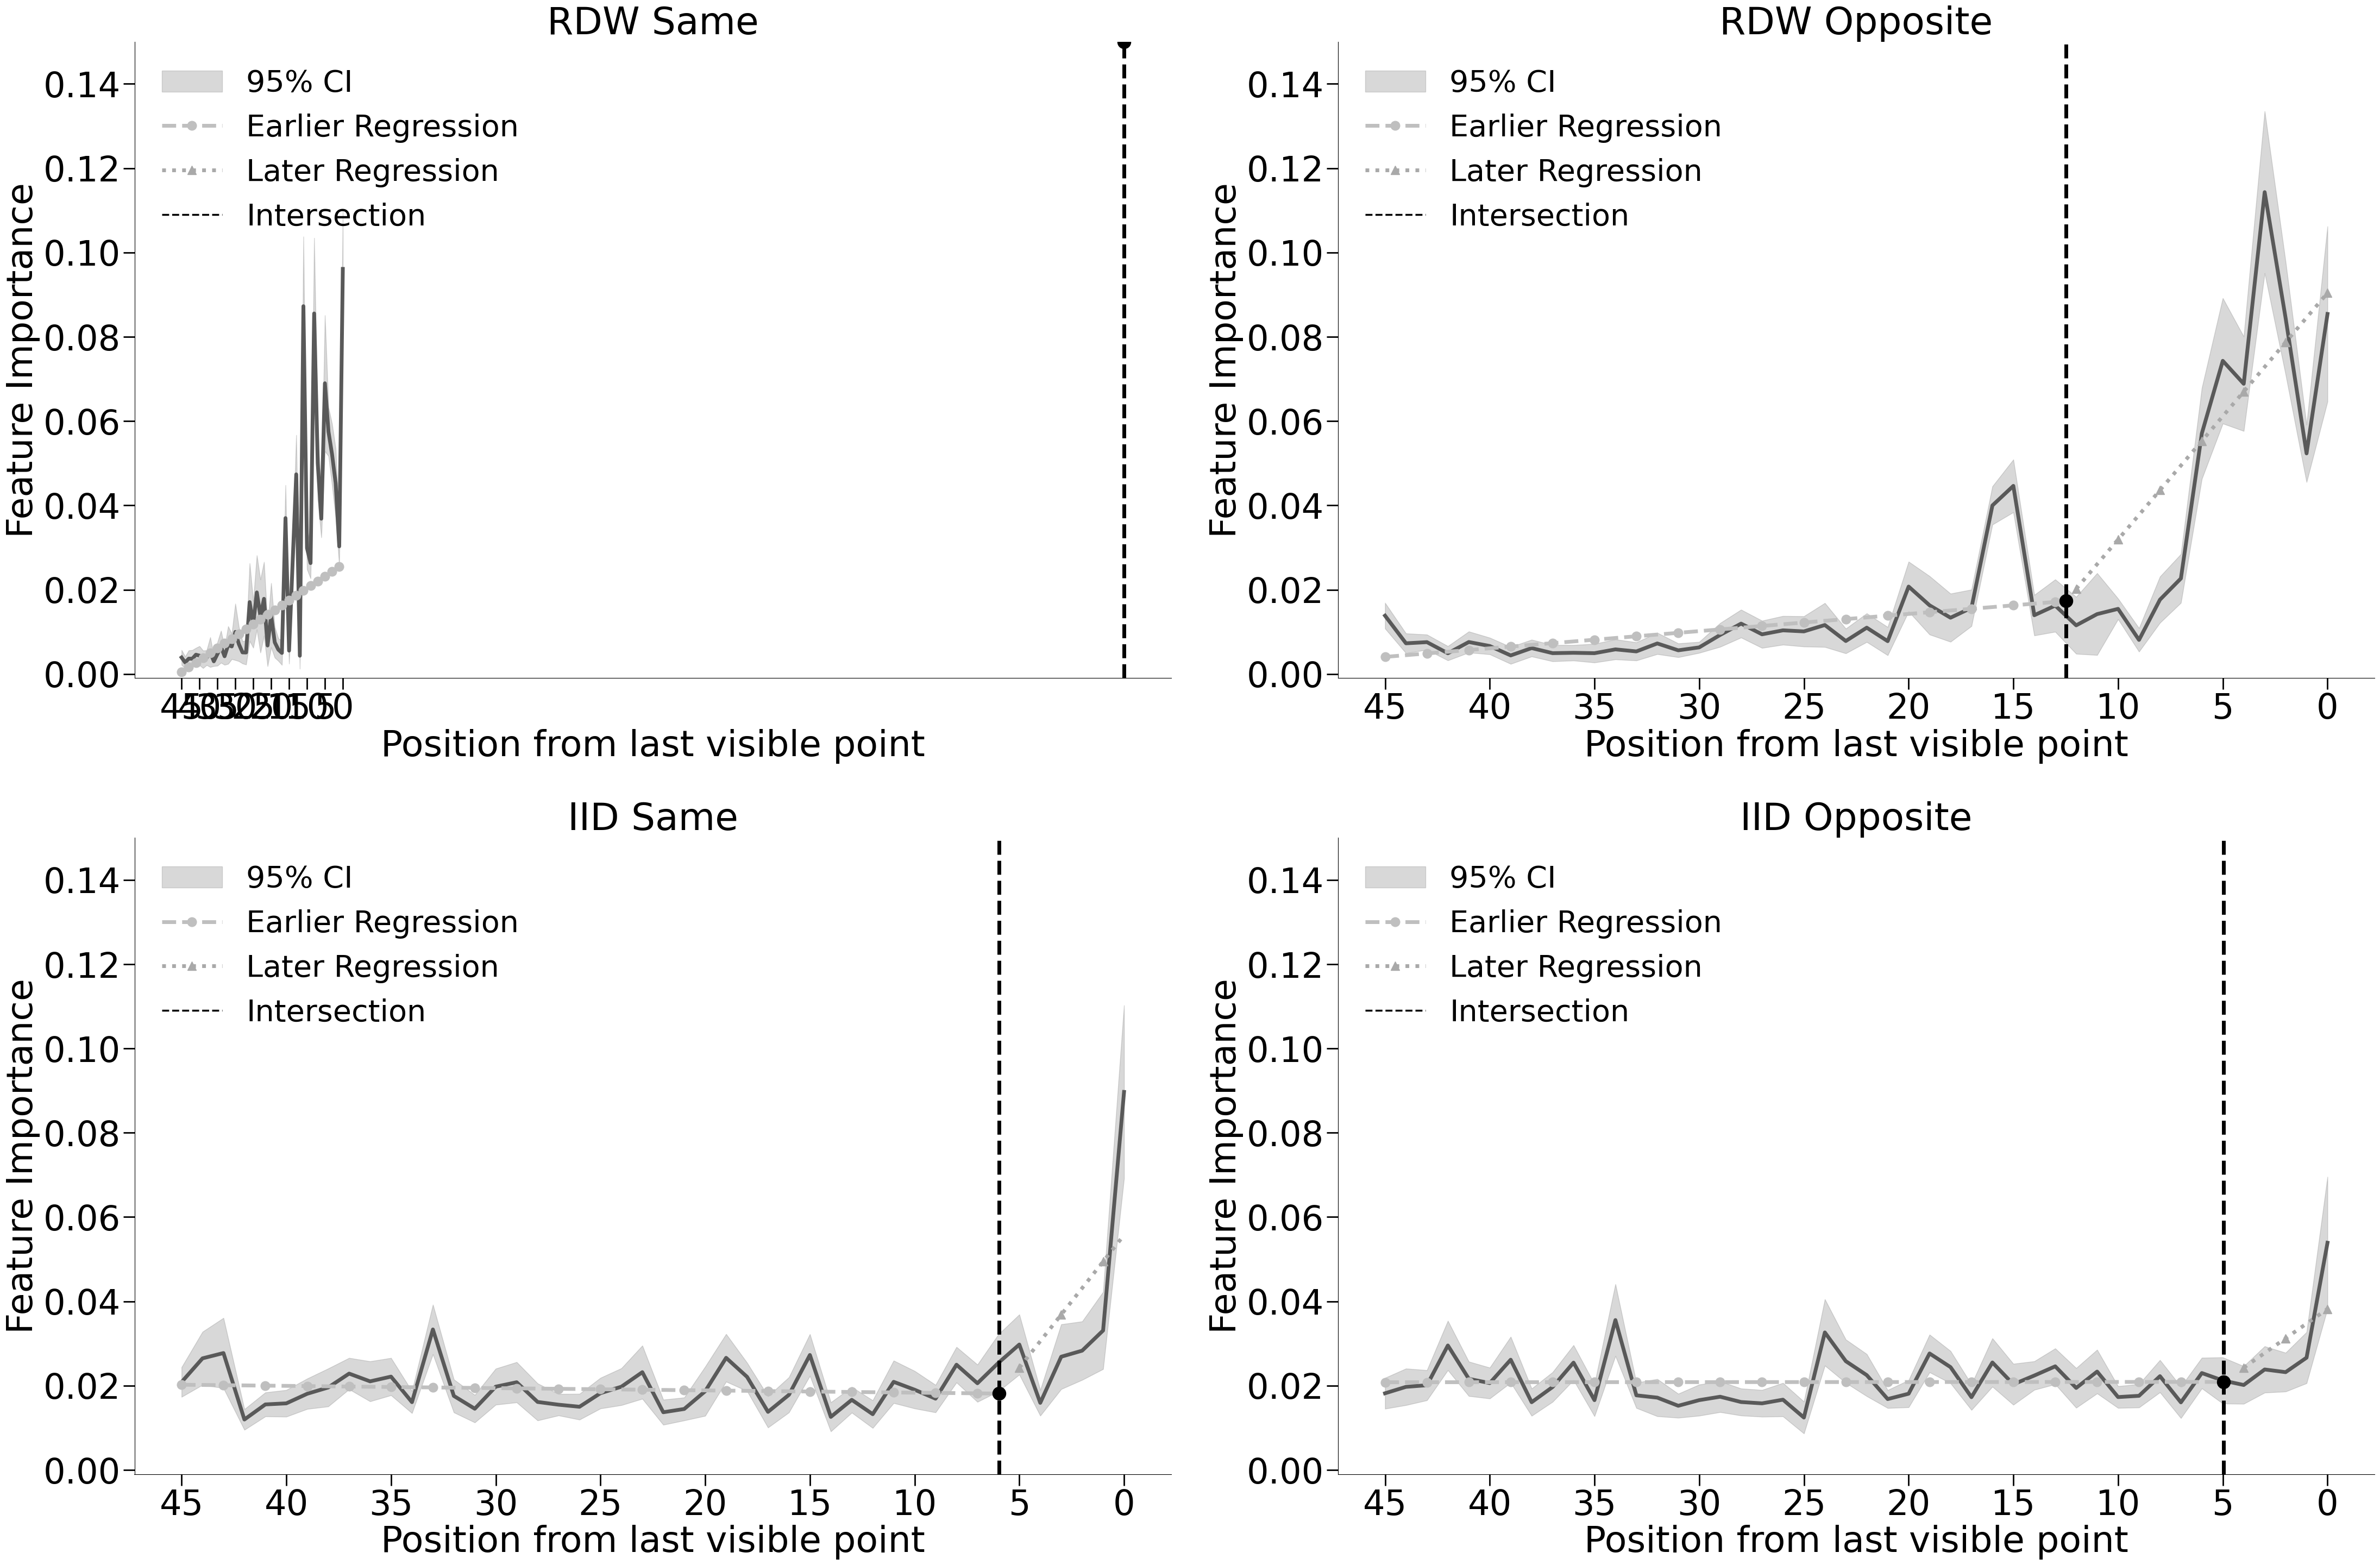

In [288]:
fig, results = find_optimal_split_and_plot_subplots(results_rdw_same, results_rdw_op, results_iid_same, results_iid_op)

Condition: RDW Same
Best x0: 40
Best Intersection: 37.836411563899325
Best Error: 0.010556504288449883
Left Regression Model: Slope=0.0006345478625440378, Intercept=-0.0030248675519914097
Right Regression Model: Slope=0.0041185079535463265, Intercept=-0.13484541542735415
--------------------------------------------------
Condition: RDW Opposite
Best x0: 41
Best Intersection: 43.00922417278938
Best Error: 0.0029518739014918107
Left Regression Model: Slope=0.0003167964658693596, Intercept=0.0031950929498868854
Right Regression Model: Slope=0.012261938934275695, Intercept=-0.5105562172497079
--------------------------------------------------
Condition: IID Same
Best x0: 45
Best Intersection: 46.77611480393543
Best Error: 0.002995448563422524
Left Regression Model: Slope=3.621980642294538e-05, Intercept=0.01608021822609681
Right Regression Model: Slope=0.012786624865617803, Intercept=-0.5803341926194809
--------------------------------------------------
Condition: IID Opposite
Best x0: 45


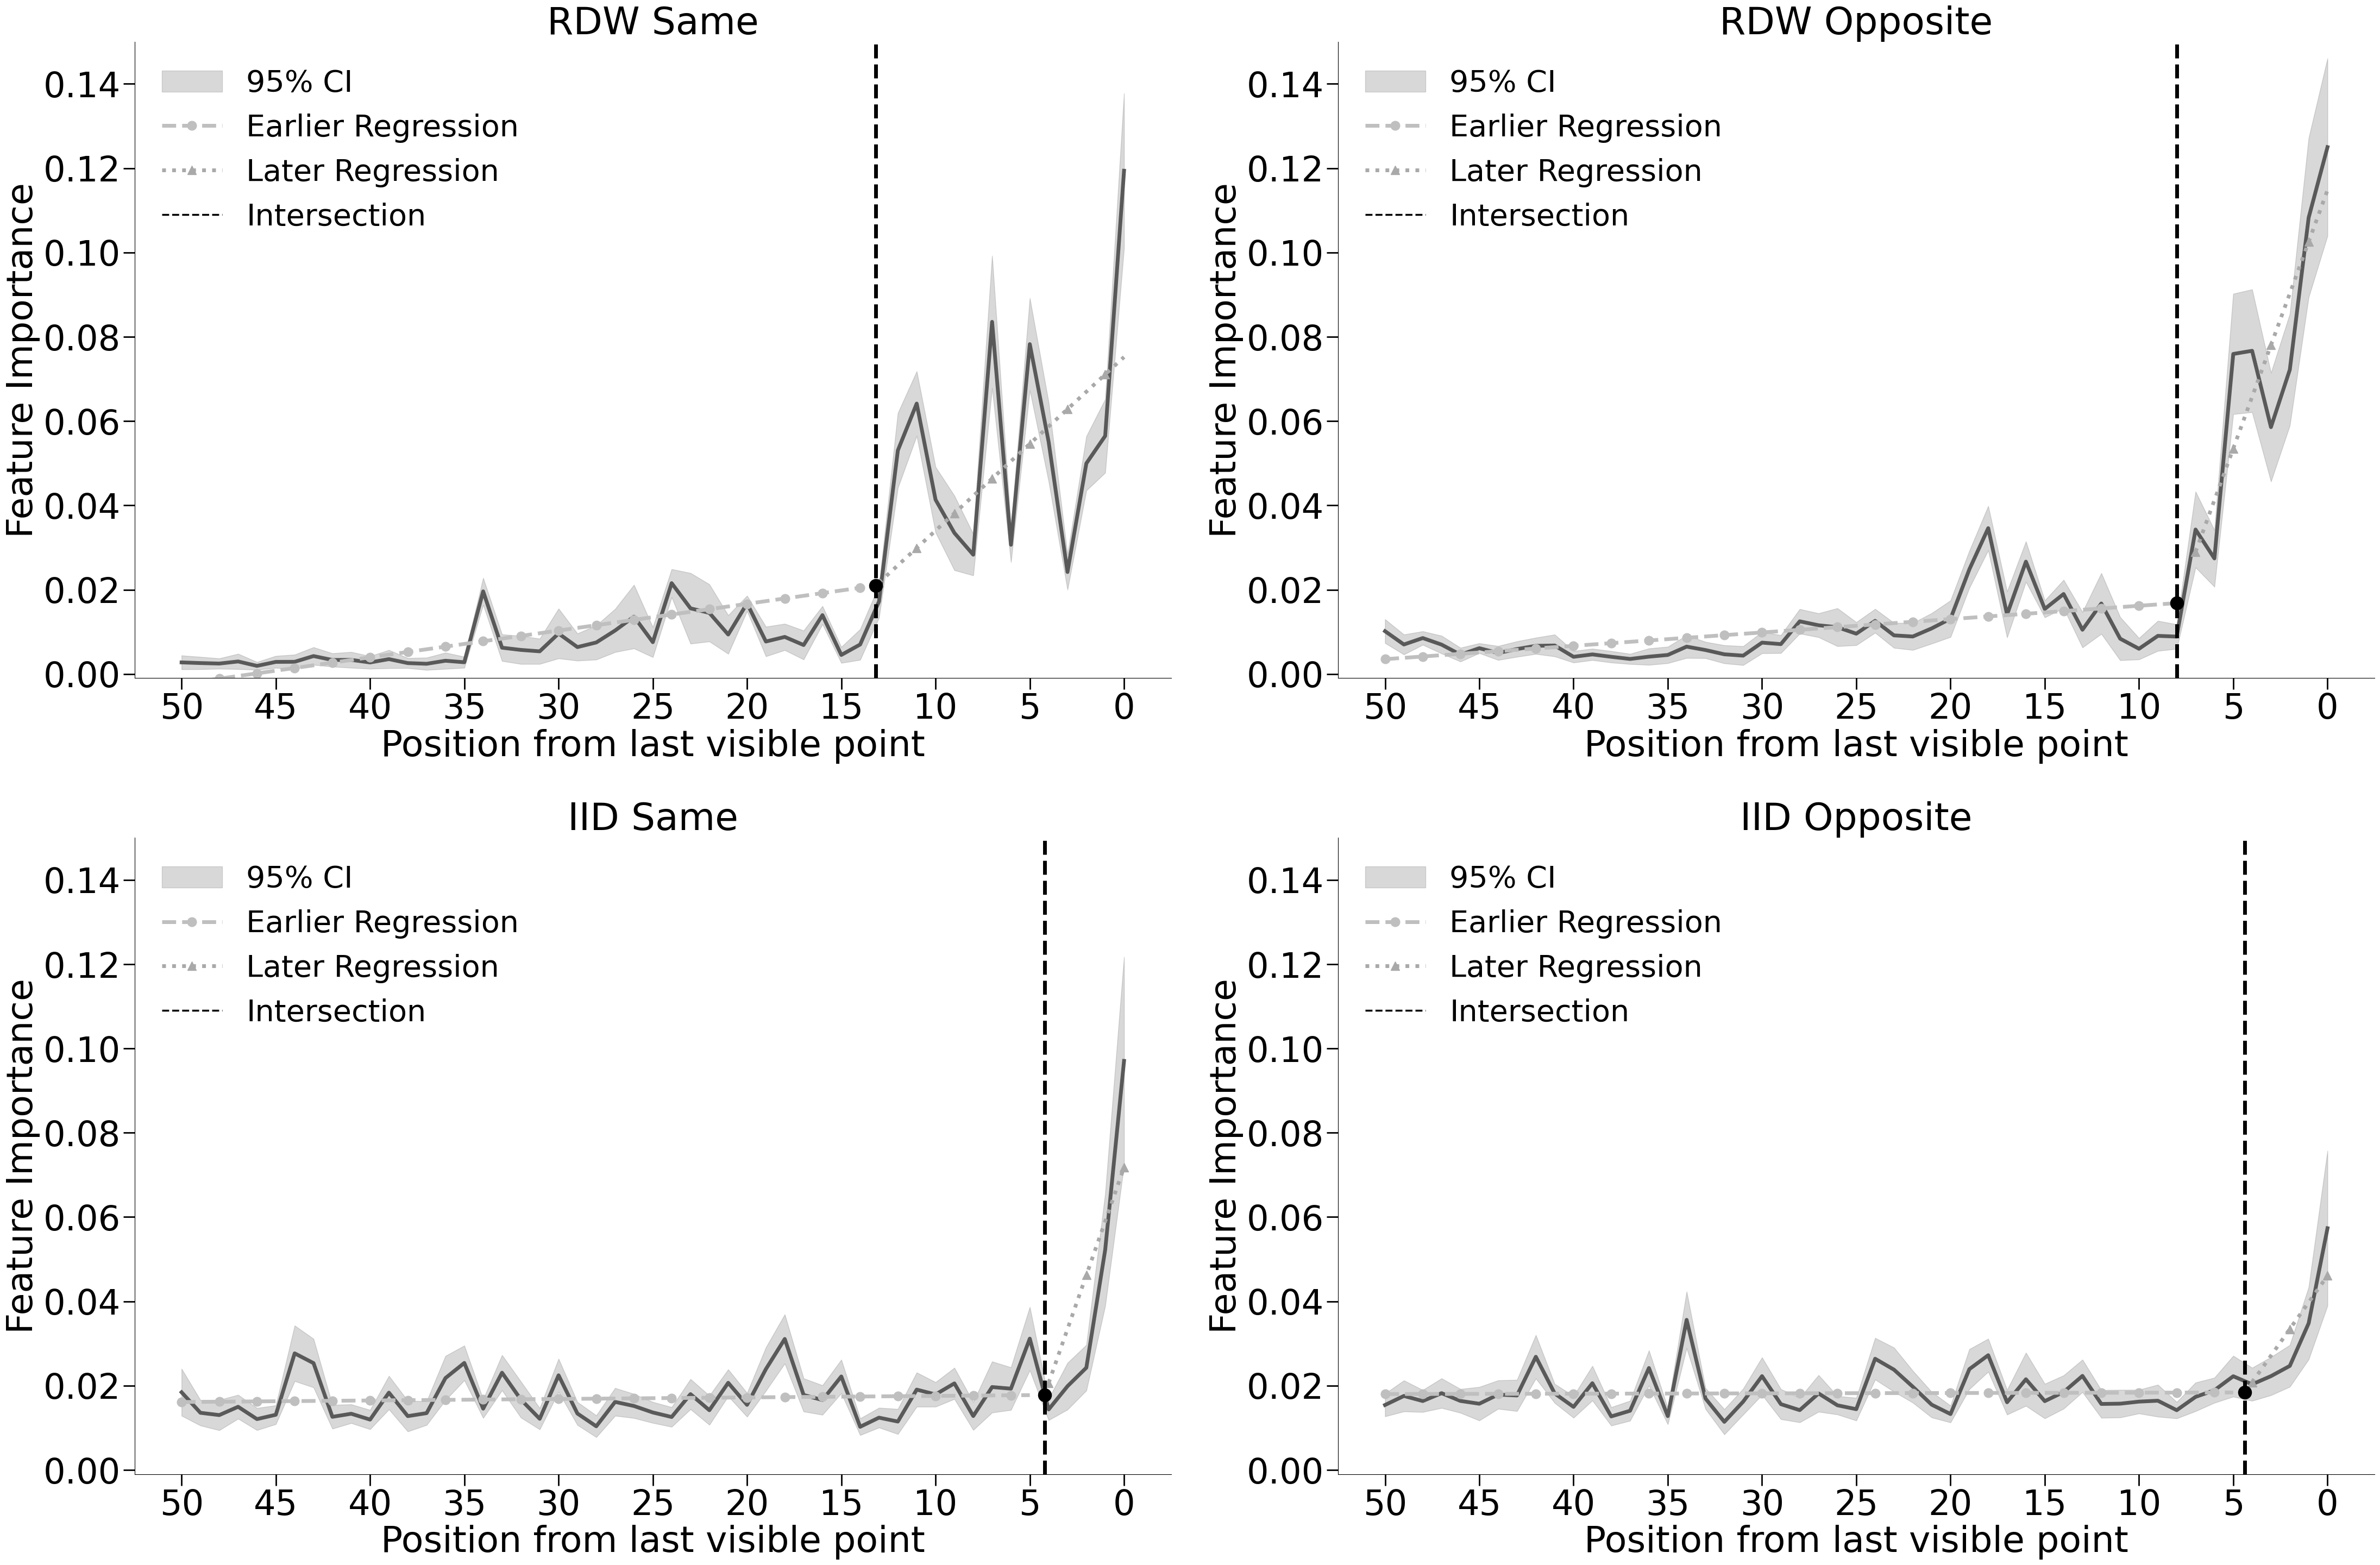

In [270]:
# Предположим, что у вас есть данные results_rdw_same, results_rdw_op, results_iid_same, results_iid_op
fig, results = find_optimal_split_and_plot_subplots(results_rdw_same, results_rdw_op, results_iid_same, results_iid_op)


for condition, data in results.items():
    print(f"Condition: {condition}")
    print(f"Best x0: {data['best_x0']}")
    print(f"Best Intersection: {data['best_intersection']}")
    print(f"Best Error: {data['best_error']}")
    print(f"Left Regression Model: Slope={data['left_regression_model']['slope']}, Intercept={data['left_regression_model']['intercept']}")
    print(f"Right Regression Model: Slope={data['right_regression_model']['slope']}, Intercept={data['right_regression_model']['intercept']}")
    print("-" * 50)